<h3><b>Homework 3 - Metodi di regressione</b></h3>

In [317]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

<p><b>Esercizio 1 - Regressione lineare semplice</b></p>

Modelli di approssimazione **polinomiali**, in cui cioè la funzione $f(x)$ si assume essere un polinomio nella variabile $x$ di grado $d$, ovvero:

$$
f(x) = a_0 + a_1 x + a_2 x^2 + \dots + a_d x^d = \sum_{k=0}^d a_k x^k.
$$

Per poi andare a risolvere la regressione lineare semplice con una fattorizzazione SVD risolvendo un problema dei minimi quadrati lineari

<b>Problema test</b><br>

In [318]:
# Definiamo la funzione f(x, alpha) che prende in input il vettore alpha dei coefficienti e un valore x, e ritorna il valore del rispettivo polinomio
def f(x, alpha):
    d = alpha.shape[0] - 1 # abbiamo detto che la shape di alpha è (d+1, ), calcola il grado del polinomio

    y = 0
    for i in range(d+1): # ciclo fra tutti i coefficenti (alpha -> vettore coefficienti)
        y = y + alpha[i] * x ** i
    return y

Definisco un vettore di parametri reali (che quindi forniranno un confronto con i dati predetti) che prende il nome di $ \alpha_{true} $.

- <i>Overfit:</i> si verifica quando il grado del polinomio è troppo alto, al punto tale per cui "impara esattamente" l'andamento dei dati
- <i>Underfit:</i> si verifica quando il grado del polinomio è troppo basso, non approssima bene i dati

In [319]:
d = 3 # grado del polinomio
alpha_true = np.ones((d+1,)) # paremtri reali per costruire problema test

# Scegliamo un valore di x
x = 3
y = f(x, alpha_true)
print(f"(x = {x}, y = {y})")

# ----- Costruzione del set di input sintetici ----- #
# Numero di dati
n = 15

# Definiamo gli x_i (costruisco vettore)
x = np.linspace(0, 1, n)


(x = 3, y = 40.0)


A questo punto, per ogni $i = 1, \dots n$, costruiamo i valori di output:

$$
y_i = f(x_i, \alpha) + e_i = \sum_{k=0}^n a_k x_i^k + e_i,
$$

dove $e_i$ è del rumore gaussiano estratto con la funzione `np.random.normal(loc=0, scale=sigma, size=(1, ))`, con deviazione standard `sigma = 0.1`. Disegneremo successivamente il grafico della curva del polinomio (che rappresenta i dati reali) e i puntini dei "dati reali" creati soltanto mediante il rumore gaussiano.

In [320]:
# Definiamo la deviazione standard del rumore
sigma = 0.1

# Generiamo il rumore
e = np.random.normal(loc=0, scale=sigma, size=(n, ))

# Inizializziamo y
y = np.zeros_like(x)

for i in range(n):
    y[i] = f(x[i], alpha_true) + e[i]

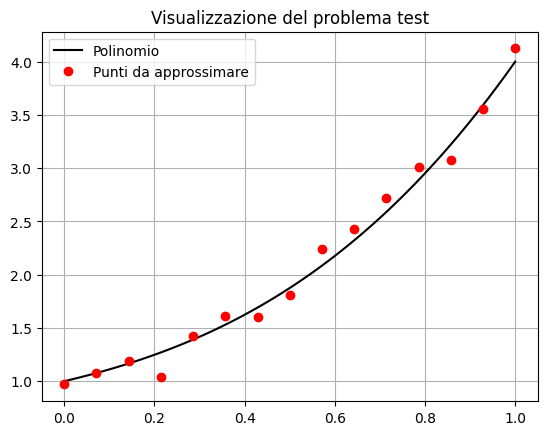

In [321]:
# Andiamo a rappresentare la curva *vera* in [0, 1]
xx = np.linspace(0, 1, 100)
yy = f(xx, alpha_true)

plt.plot(xx, yy, color='black', label='Polinomio')
plt.plot(x, y, color='red', marker='o', linestyle='', label='Punti da approssimare')
plt.grid()
plt.title("Visualizzazione del problema test")
plt.legend()
plt.show()

<b>Approssimazione ai minimi quadrati</b>

Uso la matrice Vandermonde nell'approssimazione ai minimi quadrati perché voglio passare dalla notazione algebrica a quella matriciale. Poiché il modello polinomiale è
$$
f(x) = a_0 + a_1 x + a_2 x^2 + \dots + a_d x^d = \sum_{k=0}^d a_k x^k.
$$
costruisco la matrice $X$ dove ogni riga $i$ corrisponde all'input $x_i$ elevato a potenze crescenti: 
$$
riga_i = [1, x_i, x_i^2, ..., x_i^d]
$$
Otteniamo quindi la forumla equivalente 
$$
\min_{\alpha} || X\alpha - y ||_2^2
$$


In [322]:
def vandermonde(x, d): #prendiamo il vettore x (x_1,x_2,...,x_n) e il grado del polimonio
    #ritorniamo la matrice vandermonde X di grado d, associata a x
    n = x.shape[0] #trovo la lunghezza del vettore
    X = np.zeros((n, d+1)) #tante righe quanto è lungo il vettore, e tante colonne quanto è il grado del polinomio
    for i in range(d+1): #per ogni colonna della matrice
        X[:, i] = x ** i #prendo tutta la colonna e la elevo all'indice, quindi la prima riga sarà x^0, seconda riga x^1, terza riga x^2
    return X #ritorno la matrice vandermonde

Andiamo ora a calcolare il <i>residuo</i> che è definito come: $
r(\alpha) := || X\alpha - y ||_2^2
$. <br>Il <i>residuo</i> misura la discrepanza tra la previsione del modello di approssimazione e i dati misurati. Risolvere i minimi quadrati corrisponde a minimizzare questa quantità.

In [323]:
def residuo(X, y, alpha):
    r = np.linalg.norm(X@alpha - y) ** 2
    return r

In [324]:
# Testiamo la funzione con un alpha generato casualmente
X = vandermonde(x, d)
alpha = np.random.randn(d+1)
print(f"Residuo: {residuo(X, y, alpha)}.")

Residuo: 9.465229095348374.


<b>Metodo della <i>fattorizzazione LU in decomposizione di Cholesky</i></b>
$$ X^TX=LU $$
$ U = $ risultato della riduzione <br>
$ L = $ moltiplicatori usati durante una riduzione
$$
\begin{cases}
    L z = X^T y \\
    U \alpha = z.
\end{cases}
$$
Per trovare $$min = ||X \alpha - y||_2^2$$ devo ridurmi a calcolare 
$$(X^TX)\alpha = X^Ty$$

In [325]:
def LU(X):
    # Calcolo dei termini
    Xt_X = X.T@X
    Xt_y = X.T@y

    alpha_lu = np.linalg.solve(Xt_X, Xt_y) # Risoluzione del sistema lineare
    return alpha_lu # Ritorno i coeff. del polinomio che meglio approssima

In [326]:
d = 5
X = vandermonde(x, d)
alpha_eqn = LU(X)

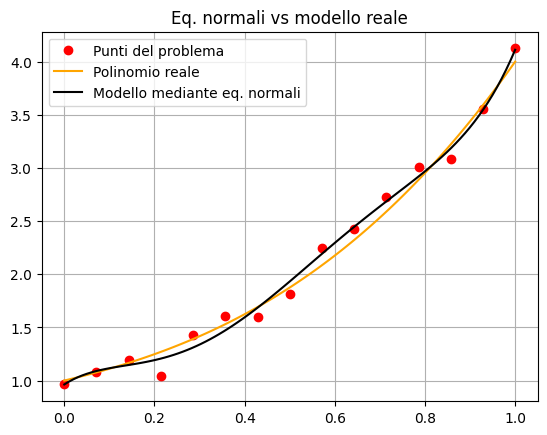

In [327]:
xx = np.linspace(0,1, 100)
yy_true = f(xx, alpha_true)
yy_eqn = f(xx, alpha_eqn)
plt.plot(x, y, color="red", marker="o", linestyle="", label='Punti del problema') #punti del problema
plt.plot(xx, yy_true, color="orange", label='Polinomio reale')
plt.plot(xx, yy_eqn, color="black", label='Modello mediante eq. normali')
plt.grid()
plt.legend()
plt.title("Eq. normali vs modello reale")
plt.show()

<b>Metodo della <i>decomposizione SVD</i></b>
$$
X = U \Sigma V^T
$$
Ricordiamo che nella decomposizione in valori singolari $U \in \mathbb{R}^{n \times n}$ e $V \in \mathbb{R}^{(d+1) \times (d+1)}$ sono matrici ortogonali, mentre $\Sigma \in \mathbb{R}^{n \times (d+1)}$ è una matrice diagonale i cui elementi sulla diagonale sono i valori singolari di $X$, in ordine decrescente. Successivamente calcoliamo la soluzione esplicita
$$
    \alpha = \sum_{i=1}^{d+1} \frac{u_i^T y}{\sigma_i} v_i. 
$$
Andiamo quindi a calcolare $||X - U \Sigma V^T||_2 $ per fare un test che tutto sia andato per il verso giusto. Siccome $ X = U \Sigma V^T $ allora $X - U \Sigma V^T$ dovrebbe essere una matrice di soli zeri e quindi la sua norma deve essere circa 0. 

In [328]:
def SVD(X, y, d):
    U, s, VT = np.linalg.svd(X)
    n = X.shape[0]
    alpha_SVD = np.zeros((d+1, ))
    for i in range(d+1):
        alpha_SVD = alpha_SVD + (U[:, i].T@y) / s[i] * VT[i, :]

    Sigma = np.zeros((n, d+1))
    for i in range(d+1):
        Sigma[i, i] = s[i]
    print(f"CHECK: ||X - U Sigma V^T|| = {np.linalg.norm(X - U@Sigma@VT)}")
    return alpha_SVD

In [329]:
# Calcoliamo la SVD di X
alpha_svd = SVD(X, y, d)

CHECK: ||X - U Sigma V^T|| = 3.541947139643134e-15


Andiamo ora a tracciare un grafico simile a quello che abbiamo fatto per la fattorizzazione LU.

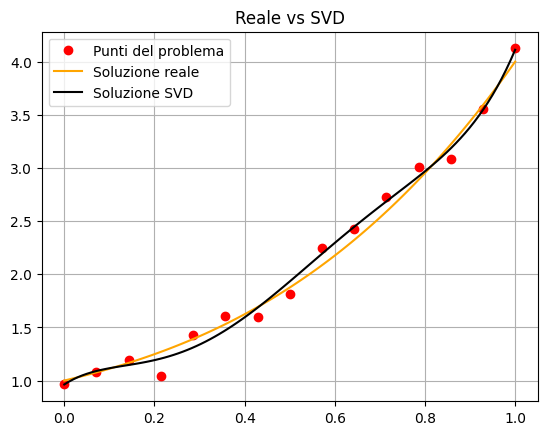

In [330]:
xx = np.linspace(0, 1, 100)
yy_true = f(xx, alpha_true)
yy_svd = f(xx,alpha_svd)
plt.plot(x,y, color="red", marker="o", linestyle="", label="Punti del problema") #punti del problema
plt.plot(xx, yy_true, color="orange", label="Soluzione reale") #soluzione corretta
plt.plot(xx, yy_svd, color="black", label="Soluzione SVD") #soluzione con SVD
plt.grid()
plt.legend()
plt.title("Reale vs SVD")
plt.show()

<b>Confrontiamo i metodi:</b> andiamo ora a visualizzare cosa succede quando andiamo a modificare il grado del polinomio.

In [331]:
def considerazioni(d, y):
    X = vandermonde(x, d)

    # equazioni normali in decomposizione LU
    alpha_LU = LU(X)
    # decomposizione SVD
    alpha_SVD = SVD(X, y, d)

    xx = np.linspace(0, 1, 100)
    yy_true = f(xx, alpha_true)
    yy_SVD = f(xx, alpha_SVD)
    yy_LU = f(xx, alpha_LU)
    plt.figure(figsize=(8, 6))
    plt.title(f"Polinomio di grado {d}, residuo SVD = {residuo(X, y, alpha_SVD)},  residuo LU = {residuo(X, y, alpha_LU)}")
    plt.plot(x, y, color='red', marker='o', linestyle='', label='Punti del problema')
    plt.plot(xx, yy_true, color='purple', label='Soluzione reale')
    plt.plot(xx, yy_SVD, color='black', label='Soluzione con SVD')
    plt.plot(xx, yy_LU, color='orange', label='Soluzione con LU', linestyle='--')
    plt.legend()
    plt.grid()
    plt.show()

CHECK: ||X - U Sigma V^T|| = 2.0380928931136654e-15


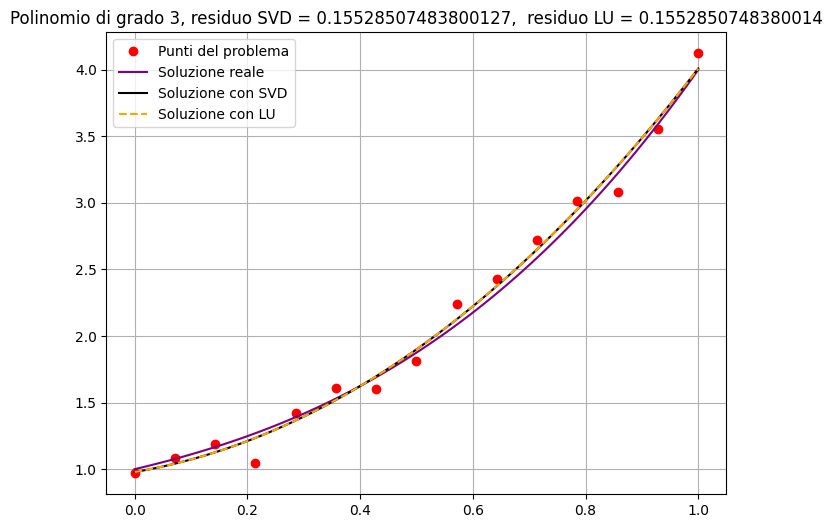

CHECK: ||X - U Sigma V^T|| = 3.9151834732816606e-15


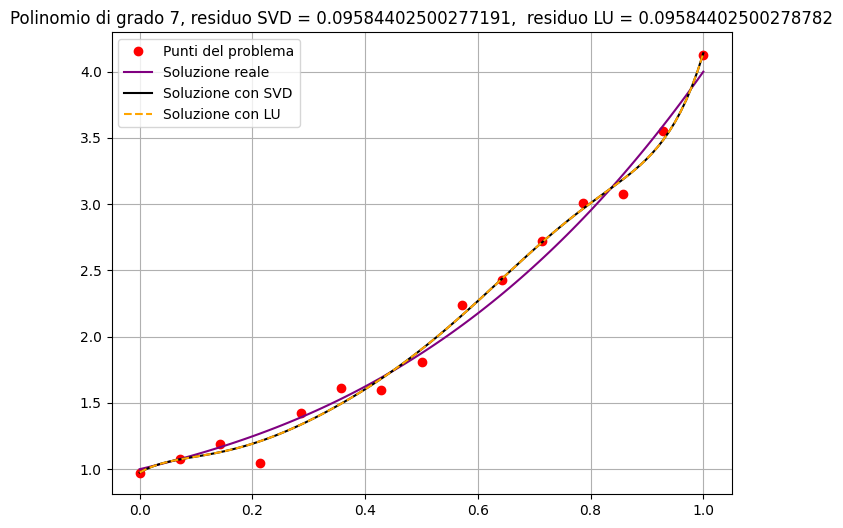

CHECK: ||X - U Sigma V^T|| = 3.2162416823763966e-15


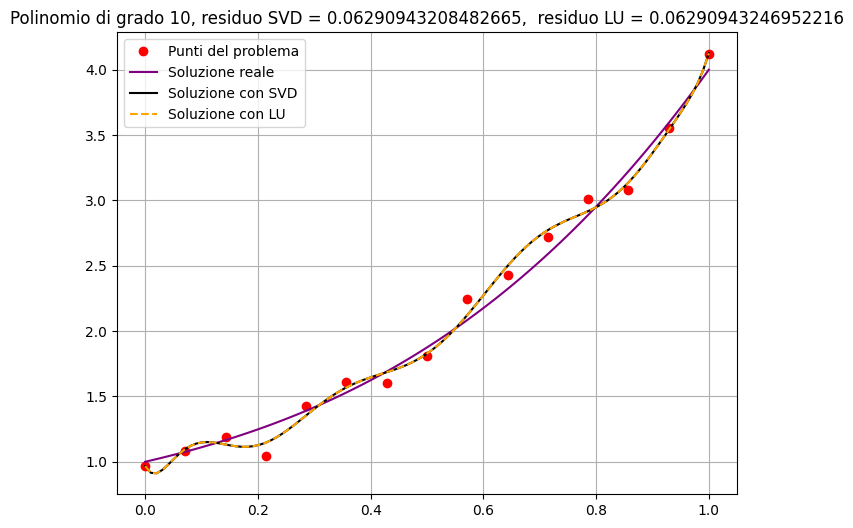

CHECK: ||X - U Sigma V^T|| = 4.423140085258716e-15


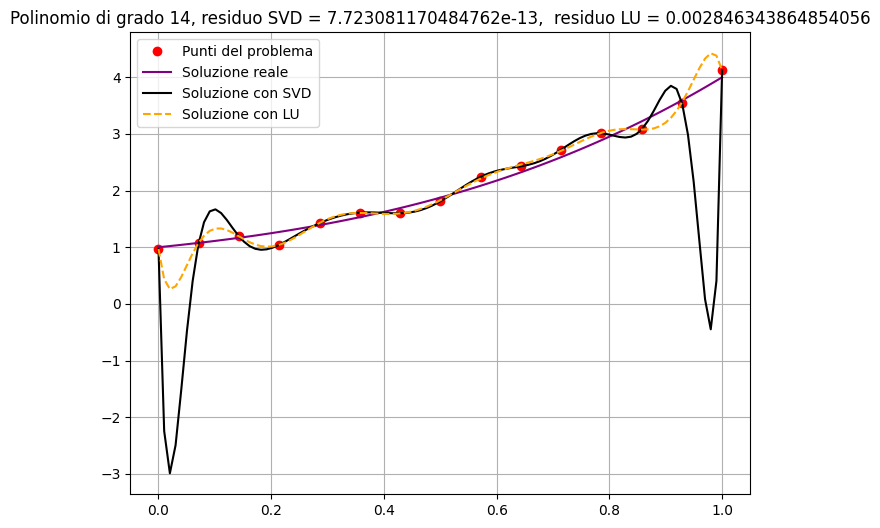

In [332]:
considerazioni(3, y)
considerazioni(7, y)
considerazioni(10, y)
considerazioni(14, y)

CHECK: ||X - U Sigma V^T|| = 5.190831003353499e-15
CHECK: ||X - U Sigma V^T|| = 5.9241118650254735e-15


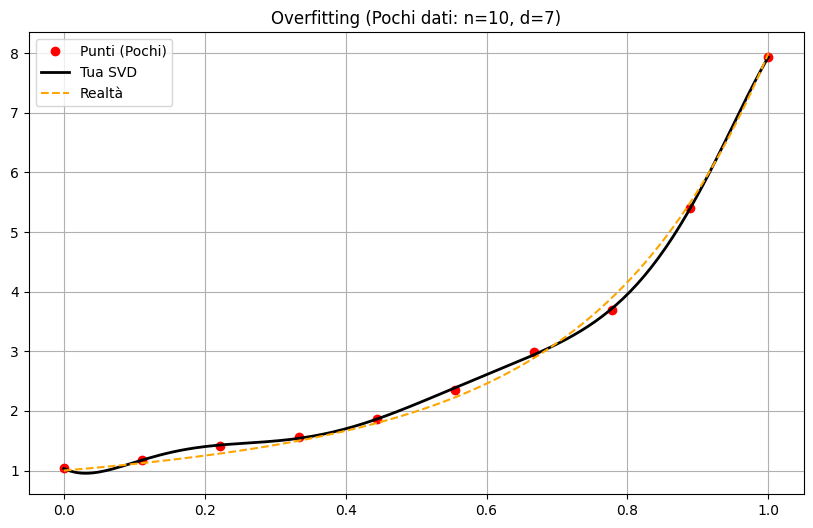

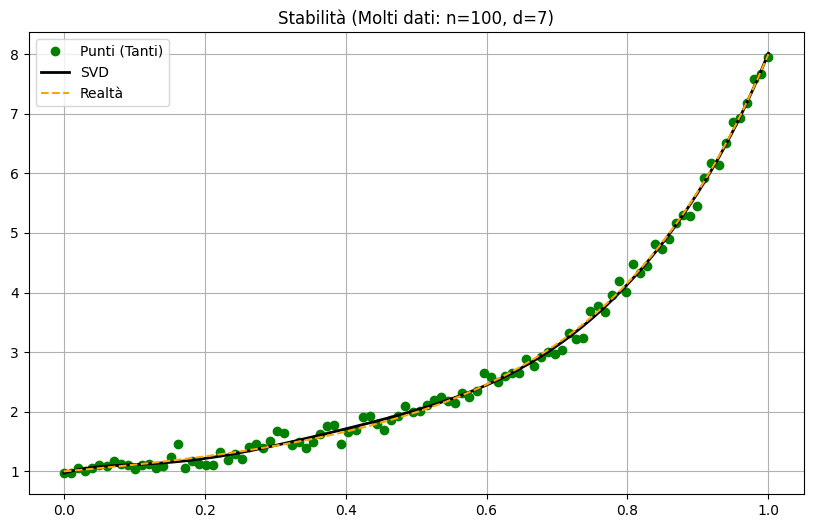

In [333]:
def confronto_punti_custom(d, n_small=10, n_large=100):
    # 1. Generiamo i parametri "veri" (alpha_true)
    # Usiamo coefficienti tutti a 1 come nel tuo esempio iniziale
    alpha_true = np.ones((d+1,))

    # --- Generazione Dati ---
    
    # Caso 1: Pochi punti (n_small)
    x_small = np.linspace(0, 1, n_small)
    # Calcoliamo y_small usando la tua funzione f(x, alpha)
    # Aggiungiamo rumore gaussiano
    y_small = np.zeros_like(x_small)
    for i in range(n_small):
        y_small[i] = f(x_small[i], alpha_true) + np.random.normal(0, 0.1)
        
    # Caso 2: Tanti punti (n_large)
    x_large = np.linspace(0, 1, n_large)
    y_large = np.zeros_like(x_large)
    for i in range(n_large):
        y_large[i] = f(x_large[i], alpha_true) + np.random.normal(0, 0.1)

    # --- Risoluzione (Usando le tue funzioni custom) ---
    
    # Risoluzione Caso Small
    X_small = vandermonde(x_small, d)      # La tua funzione vandermonde
    alpha_small = SVD(X_small, y_small, d) # La tua funzione SVD (aggiornata con y)
    
    # Risoluzione Caso Large
    X_large = vandermonde(x_large, d)      # La tua funzione vandermonde
    alpha_large = SVD(X_large, y_large, d) # La tua funzione SVD (aggiornata con y)

    # --- Plotting ---
    # Creiamo una griglia fitta per disegnare le curve lisce
    xx = np.linspace(0, 1, 200)
    
    # Calcoliamo le curve usando la tua funzione f(x, alpha)
    yy_real = f(xx, alpha_true)   # Curva reale (senza rumore)
    yy_small = f(xx, alpha_small) # Soluzione su pochi punti
    yy_large = f(xx, alpha_large) # Soluzione su tanti punti

    plt.figure(figsize=(10, 6))

    # Grafico SX: Pochi punti
    plt.title(f"Overfitting (Pochi dati: n={n_small}, d={d})")
    plt.plot(x_small, y_small, 'ro', label='Punti (Pochi)')
    plt.plot(xx, yy_small, 'k-', linewidth=2, label='Tua SVD')
    plt.plot(xx, yy_real, color='orange', linestyle='--', label='Realtà')
    plt.grid()
    plt.legend()
    plt.show
    
    plt.figure(figsize=(10, 6))
    # Grafico DX: Tanti punti
    plt.title(f"Stabilità (Molti dati: n={n_large}, d={d})")
    plt.plot(x_large, y_large, 'go', label='Punti (Tanti)')
    plt.plot(xx, yy_large, 'k-', linewidth=2, label='SVD')
    plt.plot(xx, yy_real, color='orange', linestyle='--', label='Realtà')
    plt.legend()
    plt.grid()
    plt.show()

confronto_punti_custom(d=7)

- <i>Aumentare il grado del polinomio:</i> aumentando il grado del polinomio fino a 15 notiamo che la funzione plottata segue quasi esattamente la funzione in quanto si verifica un <b>overfit</b> del modello, quindi la funzione di regressione "impara" la posizione dei punti.
- <i>Diminuire il grado del polinomio:</i> diminuendo il grado del polinomio fino ad 1 notiamo come la funzione plottata sia molto lontana dai valori reali, quindi non risulta preciso il modello nel predire i dati futuri; in questo caso si verifica un <b>underfit</b>.

<b>Utilizzo di un dataset di Kaggle</b>

In [334]:
dataset = pd.read_csv("SalaryPrediction.csv")
display(dataset)
x = dataset["Experience Years"].to_numpy()
y = dataset["Salary"].to_numpy()


,Experience Years,Salary
0,1.1,39343
1,1.2,42774
2,1.3,46205
3,1.5,37731
4,2.0,43525
5,2.2,39891
6,2.5,48266
7,2.9,56642
8,3.0,60150
9,3.2,54445


Utilizziamo il dataset sopra importato e il polinomio prima descritto per applicare un modello di regressione lineare con approssimazione ad un problema di <b>Minimi quadrati lineri.</b>

CHECK: ||X - U Sigma V^T|| = 4.042457172077866e-12


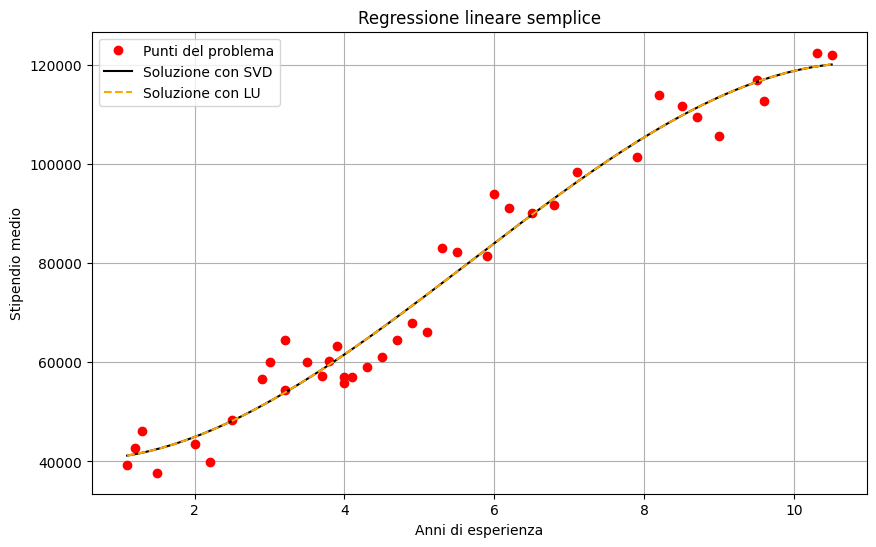

Residuo LU = 907218679.9829063 e residuo SVD = 907218679.9829068


In [335]:
d = 3
X = vandermonde(x, d)
alpha_LU = LU(X)
alpha_SVD = SVD(X, y, d)
xx = np.linspace(min(x), max(x), 3000)
yy_LU = f(xx, alpha_LU)
yy_SVD = f(xx, alpha_SVD)
plt.figure(figsize=(10, 6))
plt.title("Regressione lineare semplice")
plt.grid()
plt.plot(x, y, color='red', marker='o', linestyle='', label='Punti del problema')
plt.plot(xx, yy_SVD, color='black', label='Soluzione con SVD')
plt.plot(xx, yy_LU, color='orange', linestyle='--', label='Soluzione con LU')
plt.xlabel("Anni di esperienza")
plt.ylabel("Stipendio medio")
plt.legend()
plt.show()
print(f"Residuo LU = {residuo(X, y, alpha_LU)} e residuo SVD = {residuo(X, y, alpha_SVD)}")

<b>Considerazioni sul numero "mostruoso" di residuo</b><br>
Siccome i dati sono nel range $40.000 - 120.000$ se sbagliamo di soli 1000$ l'errore al quadrato è $1.000.000$. Se sommiamo questo errore per i 40 dati utilizzati arriviamo a valori molto alti. Vediamo il conto al contrario:
$$ RMSE = \sqrt{\frac{793403088}{40}} \approx 4.453 \$ $$
quindi, analizzando l'errore quadratico medio al contrario, risaliamo ad un errore di circa 4.500\$ che corrisponde ad un errore di circa $4-5$%.

<b>Esercizio 2: regressione lineare multipla</b>

Andiamo come prima a scariacare un dataset per una regressione lineare multipla. Introduciamo ora un parametro chiamato $ R^2 $ il quale è la "pagella" del metodo di regressione appena creato. Di fatto, è un <b>indice di bontà</b> dell'algoritmo, indica quanto è preciso nel predire i dati facendo riferimento alla regressione generata.

In [336]:
data = pd.read_csv("Student_Performance.csv")
display(data)

data['Extracurricular Activities'] = data['Extracurricular Activities'].map({'Yes': 1, 'No': 0})
features_cols = ["Hours Studied", "Sleep Hours", "Previous Scores", "Sample Question Papers Practiced", "Extracurricular Activities"]
X = data[features_cols].values
y = data["Performance Index"]


,Hours Studied,Previous Scores,Extracurricular Activities,Sleep Hours,Sample Question Papers Practiced,Performance Index
0,7,99,Yes,9,1,91.0
1,4,82,No,4,2,65.0
2,8,51,Yes,7,2,45.0
3,5,52,Yes,5,2,36.0
4,7,75,No,8,5,66.0
...,...,...,...,...,...,...
9995,1,49,Yes,4,2,23.0
9996,7,64,Yes,8,5,58.0
9997,6,83,Yes,8,5,74.0
9998,9,97,Yes,7,0,95.0


In [337]:
mse = []
r2s = []
sizes = [0.1, 0.2, 0.3, 0.4, 0.5]
for size in sizes:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=size, random_state=42)
    model = LinearRegression()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse.append(mean_squared_error(y_test, y_pred))
    r2s.append(r2_score(y_test, y_pred))
res = pd.DataFrame({
    "Test size": sizes,
    "Mean Squared Error": mse,
    "R2 Score": r2s 
})
display(res)

,Test size,Mean Squared Error,R2 Score
0,0.1,4.096440,0.989239
1,0.2,4.082628,0.988983
2,0.3,4.066564,0.989011
3,0.4,4.200018,0.988719
4,0.5,4.201784,0.988673


Avendo raggiunto un punteggio alquanto alto (quasi perfetto), proviamo a togliere la variabile che fa la maggior parte dell'apprendimento: il <i>Previous Score</i>.

In [338]:
mse_2 = []
r2s_2 = []
sizes = [0.1, 0.2, 0.3, 0.4, 0.5]

features_cols = ["Hours Studied", "Sleep Hours", "Sample Question Papers Practiced", "Extracurricular Activities"]
X = data[features_cols].values
y = data["Performance Index"]

for size in sizes:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=size, random_state=42)
    model = LinearRegression()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse_2.append(mean_squared_error(y_test, y_pred))
    r2s_2.append(r2_score(y_test, y_pred))
res_2 = pd.DataFrame({
    "Test size": sizes,
    "Mean Squared Error": mse_2,
    "R2 Score": r2s_2 
})
display(res_2)

,Test size,Mean Squared Error,R2 Score
0,0.1,318.712017,0.162746
1,0.2,319.487676,0.137883
2,0.3,320.417348,0.134147
3,0.4,320.628680,0.138806
4,0.5,318.618410,0.141075


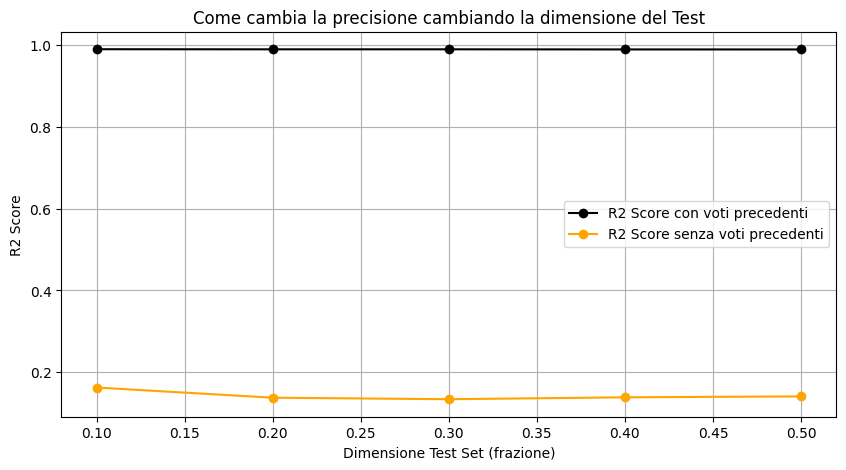

In [339]:
plt.figure(figsize=(10, 5))

# Grafico R2
plt.plot(res["Test size"], res["R2 Score"], marker='o', linestyle='-', color='black', label='R2 Score con voti precedenti')
plt.plot(res_2["Test size"], res_2["R2 Score"], marker='o', linestyle='-', color='orange', label='R2 Score senza voti precedenti')

plt.title("Come cambia la precisione cambiando la dimensione del Test")
plt.xlabel("Dimensione Test Set (frazione)")
plt.ylabel("R2 Score")
plt.grid()
plt.legend()
plt.show()

<b>Considerazioni:</b> il valore di $R^2$ è molto alto in quanto abbiamo passato come parametro anche il <i>previous score</i> (il punteggio precedente), dunque abbiamo semplicemente constatato che "chi andava bene a scuola, continua ad andare bene". I dati come le ore studiate, ore di sonno e il numero di prove fatte servono solo a limitare l'errore. <br>
Escludendo lo storico dello studente, stiamo chiedendo al modello di predire il voto basandosi solo sullo sforzo attuale (studio, sonno, esercizi). È normale che la precisione scenda, perché non stiamo considerando la base di partenza dello studente.<br>
<i>Questo ci insegna una dura lezione di realtà: la preparazione di base conta tantissimo (85%), ma le nostre abitudini quotidiane (studio/sonno) possono influenzare il restante 15% del risultato finale.</i>